# Introduction

This is a workbook on creating artificial intelligence models to classify gene expression data by tissue types.

A random forest and a neural net classifiers will be built and used on a subset of the GTEX expression data set.

To do this, we will:
 1. Download GTEX expression data
 1. Add tissue labels for the expression data
 1. Build a random forest classifier
 1. Build a neural net classifier

# Fastai and Fastbook

This is mostly based on the fastai book 'Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD' by Jeremy Howard and Sylvain Gugger.

https://www.fast.ai/

The book can be downloaded and run as jupyter notebooks, checked out of github.

https://github.com/fastai/fastbook



## ML Imports

In [1]:
from fastai.tabular.all import (L, F, Categorify, FillMissing, Normalize, TabularPandas,
                                cont_cat_split, save_pickle, load_pickle, tabular_learner, tensor)
from fastbook import cluster_columns, draw_tree

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from dtreeviz.trees import dtreeviz
import matplotlib.pyplot as plt

# GTEX Data

https://gtexportal.org/home/

The Genotype-Tissue Expression (GTEx) project is an ongoing effort to build a comprehensive public resource to study tissue-specific gene expression and regulation.

Samples were collected from 54 non-diseased tissue sites across nearly 1000 individuals.

From GTEX we will:
 - download gene expression data in Transcripts Per Million (tpm) for the V8 samples
 - download sample descriptions

## Download GTEX Data - check for downloaded files

GTEXV8_TPM is a large file over 1Gb.

The code below is downloading the files to a local folder called 'data'.

In [2]:
import os
import pandas as pd
import numpy as np
import pathlib

from logzero import logger
import pickle
from tqdm import tqdm
import requests


# GTEx data from https://gtexportal.org/home/datasets
# Gene transcripts per million data

GTEX_URL =  "https://storage.googleapis.com/gtex_analysis_v8"

GTEXV8_TPM = os.path.join(GTEX_URL, "rna_seq_data", "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz")
GTEXV8_TPM_MED = os.path.join(GTEX_URL, "rna_seq_data", "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz")
GTEX_PHENO_DS = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt")
GTEX_PHENO_DD = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SubjectPhenotypesDD.xlsx")
GTEX_SAMPLE_DS = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")
GTEX_SAMPLE_DD = os.path.join(GTEX_URL, "annotations", "GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx")

script_dir = pathlib.Path().resolve()
cache_dir = os.path.join(script_dir, "data")

if os.path.exists(cache_dir):
    logger.info(f"Found {cache_dir}")
else:
    os.mkdir(cache_dir)

for url in [GTEXV8_TPM_MED, GTEXV8_TPM, GTEX_PHENO_DS, GTEX_PHENO_DD, GTEX_SAMPLE_DS, GTEX_SAMPLE_DD]:
    dest = os.path.join(cache_dir, os.path.basename(url))
    if os.path.exists(dest):
        logger.info(f"found existing: {dest}")
    else:
        logger.info(f"Downloading {dest}")
        # Open a handle onto the GTEx expression data
        response = requests.get(url, stream=True)

        with open(dest, "wb") as fh:
            for data in tqdm(response.iter_content()):
                fh.write(data)
        logger.info(f"Completed {dest}")

[I 230227 15:35:21 2319917902:28] Found /home/dustin/fleet_gene_update/data
[I 230227 15:35:21 2319917902:35] found existing: /home/dustin/fleet_gene_update/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz
[I 230227 15:35:21 2319917902:35] found existing: /home/dustin/fleet_gene_update/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
[I 230227 15:35:21 2319917902:35] found existing: /home/dustin/fleet_gene_update/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt
[I 230227 15:35:21 2319917902:35] found existing: /home/dustin/fleet_gene_update/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDD.xlsx
[I 230227 15:35:21 2319917902:35] found existing: /home/dustin/fleet_gene_update/data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt
[I 230227 15:35:21 2319917902:35] found existing: /home/dustin/fleet_gene_update/data/GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx


## Prepare GTEX Data

### Get samples with RNASEQ Expression data

In [3]:
# Load attributues first
gtex_attr_fn = os.path.join(cache_dir, os.path.basename(GTEX_SAMPLE_DS))
gtex_attr = pd.read_csv(gtex_attr_fn, sep="\t")
gtex_attr.head(2)

SAMPID  SMATSSCR SMCENTER SMPTHNTS  SMRIN   SMTS  \
0  GTEX-1117F-0003-SM-58Q7G       NaN       B1      NaN    NaN  Blood   
1  GTEX-1117F-0003-SM-5DWSB       NaN       B1      NaN    NaN  Blood   

         SMTSD  SMUBRID  SMTSISCH  SMTSPAX  SMNABTCH  \
0  Whole Blood  0013756    1188.0      NaN  BP-38516   
1  Whole Blood  0013756    1188.0      NaN  BP-38516   

                                            SMNABTCHT   SMNABTCHD  \
0  DNA isolation_Whole Blood_QIAGEN Puregene (Manual)  05/02/2013   
1  DNA isolation_Whole Blood_QIAGEN Puregene (Manual)  05/02/2013   

           SMGEBTCH   SMGEBTCHD                           SMGEBTCHT SMAFRZE  \
0        LCSET-4574  01/15/2014  Standard Exome Sequencing v3 (ICE)     WES   
1  GTEx_OM25_Dec_01  01/28/2014             Illumina OMNI SNP Array    OMNI   

  SMGTC  SME2MPRT  SMCHMPRS  SMNTRART  SMNUMGPS  SMMAPRT  SMEXNCRT  SM550NRM  \
0   NaN       NaN       NaN       NaN       NaN      NaN       NaN       NaN   
1   NaN       NaN       NaN       NaN       NaN      NaN       NaN       NaN   

   SMGNSDTC  SMUNMPRT  SM350NRM  SMRDLGTH  SMMNCPB  SME1MMRT  SMSFLGTH  \
0       NaN       NaN       NaN       NaN      NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN      NaN       NaN       NaN   

   SMESTLBS  SMMPPD  SMNTERRT  SMRRNANM  SMRDTTL  SMVQCFL  SMMNCV  SMTRSCPT  \
0       NaN     NaN       NaN       NaN      NaN      NaN     NaN       NaN   
1       NaN     NaN       NaN       NaN      NaN      NaN     NaN       NaN   

   SMMPPDPR  SMCGLGTH  SMGAPPCT  SMUNPDRD  SMNTRNRT  SMMPUNRT  SMEXPEFF  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   SMMPPDUN  SME2MMRT  SME2ANTI  SMALTALG  SME2SNSE  SMMFLGTH  SME1ANTI  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   SMSPLTRD  SMBSMMRT  SME1SNSE  SME1PCTS  SMRRNART  SME1MPRT  SMNUM5CD  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   SMDPMPRT  SME2PCTS  
0       NaN       NaN  
1       NaN       NaN

In [4]:
# Use only the RNASEQ samples
rna_seq_patients = gtex_attr[gtex_attr["SMAFRZE"] == "RNASEQ"]["SAMPID"].tolist()
print(f'Using only RNASEQ {len(rna_seq_patients)} records')

Using only RNASEQ 17382 records


### Choose Subset of samples

Choose a smaller set of samples if you have memory errors.

In [5]:
# Choose a random sample of 1/5 the patients
import random
random.seed(42)

# Choose a smaller set of samples if you have memory errors.
GTEX_FRAC = 0.2

patient_list = random.sample(rna_seq_patients, int(len(rna_seq_patients) * GTEX_FRAC))

# Leaves a reserve list for validating with later.
reserve_patients = [patient for patient in rna_seq_patients if patient not in patient_list]

print(f'Total of {len(patient_list)} patients as {GTEX_FRAC} of GTEX RNASEQ samples.')
print(f'Using {len(patient_list)} RNASEQ patients with a reserve of {len(reserve_patients)})')

Total of 3476 patients as 0.2 of GTEX RNASEQ samples.
Using 3476 RNASEQ patients with a reserve of 13906)


In [6]:
gtex_tpm_fn = os.path.join(cache_dir, os.path.basename(GTEXV8_TPM))
logger.info(f"Starting g8 load of {len(patient_list)} samples from {gtex_tpm_fn}")

_g8 = pd.read_csv(
        gtex_tpm_fn,
        skiprows=2,  # First 2 rows are comments of file size - other func here to select genes
        sep='\t',
        header=0,
        usecols=["Description"] + patient_list,  # Number of samples limit
    )

logger.info("\tfinished g8 load")
_g8.info()

[I 230227 15:35:22 3472410461:2] Starting g8 load of 3476 samples from /home/dustin/fleet_gene_update/data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
[I 230227 15:37:12 3472410461:12] 	finished g8 load


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56200 entries, 0 to 56199
Columns: 3477 entries, Description to GTEX-ZZPU-2226-SM-5EGIV
dtypes: float64(3476), object(1)
memory usage: 1.5+ GB


### Prepare Gene expression DataFrame

In [7]:
print("Removing ambiguous gene descriptions")
# just remove anything ambiguous
dups = _g8[_g8["Description"].duplicated()]["Description"].to_list()
_g8 = _g8[~(_g8["Description"].isin(dups))]
_g8.info()

Removing ambiguous gene descriptions
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54393 entries, 0 to 56199
Columns: 3477 entries, Description to GTEX-ZZPU-2226-SM-5EGIV
dtypes: float64(3476), object(1)
memory usage: 1.4+ GB


In [8]:
_g8.head()

Description  GTEX-1117F-1326-SM-5EGHH  GTEX-111CU-0226-SM-5GZXC  \
0      DDX11L1                     0.000                   0.04667   
1       WASH7P                     5.389                   1.82300   
2    MIR6859-1                     0.000                   0.00000   
3  MIR1302-2HG                     0.000                   0.04659   
4      FAM138A                     0.000                   0.03310   

   GTEX-111CU-0726-SM-5GZYD  GTEX-111CU-1126-SM-5EGIM  \
0                   0.06455                   0.00000   
1                   0.95250                   4.45900   
2                   0.00000                   0.00000   
3                   0.00000                   0.00000   
4                   0.03052                   0.04188   

   GTEX-111FC-0526-SM-5GZZ8  GTEX-111FC-0826-SM-5GZWO  \
0                   0.00000                   0.00000   
1                   7.51700                   2.45800   
2                   0.00000                   0.00000   
3                   0.00000                   0.03116   
4                   0.04789                   0.00000   

   GTEX-111FC-1926-SM-5GZYC  GTEX-111VG-0008-SM-5Q5BG  \
0                    0.5085                    0.0000   
1                    5.3240                    0.9979   
2                    0.0000                    0.0000   
3                    0.0000                    0.0000   
4                    0.0000                    0.0000   

   GTEX-111VG-1626-SM-5EGIO  GTEX-111VG-2426-SM-5GZXD  \
0                    0.0000                    0.0000   
1                    2.7940                    2.9820   
2                    0.6737                    0.0000   
3                    0.0000                    0.0000   
4                    0.0000                    0.0361   

   GTEX-111YS-0006-SM-5NQBE  GTEX-111YS-1226-SM-5EGGJ  \
0                   0.02171                    0.0000   
1                   1.55500                    0.7417   
2                   0.00000                    0.0000   
3                   0.00000                    0.0000   
4                   0.00000                    0.0000   

   GTEX-111YS-1326-SM-5EGGK  GTEX-111YS-2326-SM-5987L  \
0                    0.0000                   0.00000   
1                    0.6725                   0.85420   
2                    0.0000                   0.00000   
3                    0.0000                   0.00000   
4                    0.0000                   0.06418   

   GTEX-1122O-0005-SM-5O99J  GTEX-1122O-0226-SM-5N9DA  \
0                   0.03015                     0.000   
1                   2.74700                     4.191   
2                   0.00000                     0.000   
3                   0.00000                     0.000   
4                   0.00000                     0.000   

   GTEX-1122O-0426-SM-5H12G  GTEX-1122O-0726-SM-5GIEV  \
0                   0.03109                   0.00000   
1                   2.46900                   1.24200   
2                   0.00000                   0.00000   
3                   0.00000                   0.02608   
4                   0.00000                   0.00000   

   GTEX-1122O-1326-SM-5H11F  GTEX-1122O-2126-SM-5EGIR  \
0                     0.000                   0.02869   
1                     2.486                   4.07200   
2                     0.000                   0.00000   
3                     0.000                   0.05729   
4                     0.000                   0.00000   

   GTEX-1128S-0726-SM-5N9D6  GTEX-1128S-1626-SM-5H12O  \
0                   0.03121                   0.05003   
1                   4.22700                   5.99300   
2                   0.00000                   0.00000   
3                   0.00000                   0.00000   
4                   0.04427                   0.03548   

   GTEX-113IC-0008-SM-5QGRF  GTEX-113JC-1026-SM-5H117  \
0                   0.00000                   0.05014   
1                   2.44100           

### Swap Row and Columns

For the machine learning tools, we wish to have columns of Genes (features), with rows of samples.

In [9]:
# Switch to columns of genes and rows of patients
# 'Description' is gene name description - alternate index column is 'Name' for ENSEMBL gene id
_g8.set_index("Description", inplace=True)
_g8.T.head(3)

Description               DDX11L1  WASH7P  MIR6859-1  MIR1302-2HG  FAM138A  \
GTEX-1117F-1326-SM-5EGHH  0.00000  5.3890        0.0      0.00000  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.04667  1.8230        0.0      0.04659  0.03310   
GTEX-111CU-0726-SM-5GZYD  0.06455  0.9525        0.0      0.00000  0.03052   

Description               OR4G4P  OR4G11P    OR4F5  RP11-34P13.7   CICP27  \
GTEX-1117F-1326-SM-5EGHH  0.0613  0.00000  0.05609       0.05006  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.0000  0.00000  0.04395       0.00000  0.05827   
GTEX-111CU-0726-SM-5GZYD  0.0000  0.03958  0.08106       0.03617  0.41910   

Description               RP11-34P13.15  RP11-34P13.16  RP11-34P13.14  \
GTEX-1117F-1326-SM-5EGHH          2.387          3.626         0.0000   
GTEX-111CU-0226-SM-5GZXC          5.825         16.200         0.6246   
GTEX-111CU-0726-SM-5GZYD         11.580         31.050         1.1520   

Description               RP11-34P13.13  RNU6-1100P  RP11-34P13.9  \
GTEX-1117F-1326-SM-5EGHH         0.1080         0.0           0.0   
GTEX-111CU-0226-SM-5GZXC         0.0977         0.0           0.0   
GTEX-111CU-0726-SM-5GZYD         0.3123         0.0           0.0   

Description               ABC7-43046700E7.1  RP11-34P13.18  MIR6859-2  \
GTEX-1117F-1326-SM-5EGHH            0.09033          4.349        0.0   
GTEX-111CU-0226-SM-5GZXC            0.07079          6.065        0.0   
GTEX-111CU-0726-SM-5GZYD            0.45690          3.222        0.0   

Description               AP006222.2  RPL23AP24  RP5-857K21.15  RP4-669L17.2  \
GTEX-1117F-1326-SM-5EGHH      0.1582        0.0            0.0           0.0   
GTEX-111CU-0226-SM-5GZXC      0.3944        0.0            0.0           0.0   
GTEX-111CU-0726-SM-5GZYD      0.3117        0.0            0.0           0.0   

Description               RP4-669L17.10  WBP1LP7   OR4F29    CICP7  \
GTEX-1117F-1326-SM-5EGHH         0.1699   0.0000  0.05483  0.00000   
GTEX-111CU-0226-SM-5GZXC         0.1997   0.0000  0.08594  0.03294   
GTEX-111CU-0726-SM-5GZYD         0.0789   0.1025  0.07924  0.01519   

Description               RP4-669L17.8  RP5-857K21.4  RP5-857K21.2  MTND1P23  \
GTEX-1117F-1326-SM-5EGHH       0.04156       0.04116           0.0    34.880   
GTEX-111CU-0226-SM-5GZXC       0.00000       0.00000           0.0     8.569   
GTEX-111CU-0726-SM-5GZYD       0.00000       0.25770           0.0     7.501   

Description               MTND2P28  MTCO1P12  MTCO2P12  MTATP8P1  MTATP6P1  \
GTEX-1117F-1326-SM-5EGHH     496.5     23.62     12.99     50.53    4094.0   
GTEX-111CU-0226-SM-5GZXC     814.7     51.45     17.16     30.83    4103.0   
GTEX-111CU-0726-SM-5GZYD     463.9     40.53     15.33     18.95    2520.0   

Description               MTCO3P12  WBP1LP6   OR4F16  RP11-206L10.17   CICP3  \
GTEX-1117F-1326-SM-5EGHH     47.43   0.1214  0.00000             0.0  0.2520   
GTEX-111CU-0226-SM-5GZXC     17.74   0.0000  0.00000             0.0  0.3456   
GTEX-111CU-0726-SM-5GZYD     29.30   0.1755  0.07924             0.0  0.1821   

Description               RP11-206L10.2  RNU6-1199P  RP11-206L10.4  \
GTEX-1117F-1326-SM-5EGHH          1.617       0.000        0.00000   
GTEX-111CU-0226-SM-5GZXC          2.647       0.388        0.00000   
GTEX-111CU-0726-SM-5GZYD          1.776       0.000        0.08159   

Description               RP11-206L10.9  RP11-206L10.8  FAM87B  LINC01128  \
GTEX-1117F-1326-SM-5EGHH         0.4480         0.3871  0.4486      3.755   
GTEX-111CU-0226-SM-5GZXC         0.8264         1.0620  1.0290      7.245   
GTEX-111CU-0726-SM-5GZYD         0.4990         0.7693  0.2547      3.607   

Description               LINC00115   FAM41C  TUBB8P11  FAM166AP3  \
GTEX-1117F-1326-SM-5EGHH      7.818  0.07293    0.1884     0.0000   
GTEX-111CU-0226-SM-5GZXC      6.324  0.02858    0.1476     0.0000   
GTEX-111CU-0726-SM-5GZYD      2.399  0.02635    0.0000     0.0721   

Description               RP11-54O7.16  RP11-54O7.1  RP11-54O7.2  RP11-54O7.3  \
GTEX-1117F

# One-hot Encode Tissue Categories

At this point we have a table of gene expression per sample, with one column per gene in the sample.

We will add a new column for every tissue type ('Kidney', 'Liver', 'Lung') we want to consider.
The column will only values 1 or 0.  The goal is to have a table of only numbers.

In [10]:
# one-hot encode the tissue categories - make one column per tissue type with 1/0 type

# get a table of tissue per patient to work with
gtex_attr.head(2)
tissues = gtex_attr.set_index("SAMPID")["SMTS"].astype("category")
tissues

SAMPID
GTEX-1117F-0003-SM-58Q7G               Blood
GTEX-1117F-0003-SM-5DWSB               Blood
GTEX-1117F-0003-SM-6WBT7               Blood
GTEX-1117F-0011-R10a-SM-AHZ7F          Brain
GTEX-1117F-0011-R10b-SM-CYKQ8          Brain
                                    ...     
K-562-SM-E9EZC                   Bone Marrow
K-562-SM-E9EZI                   Bone Marrow
K-562-SM-E9EZO                   Bone Marrow
K-562-SM-E9EZT                   Bone Marrow
K-562-SM-E9EZZ                   Bone Marrow
Name: SMTS, Length: 22951, dtype: category
Categories (31, object): ['Adipose Tissue', 'Adrenal Gland', 'Bladder', 'Blood', ..., 'Testis', 'Thyroid', 'Uterus', 'Vagina']

In [11]:
# pandas get_dummies creates a one-hot encoded table of the column
tissue_df = pd.get_dummies(tissues, dtype=float)
# print(tissue_df.columns)
tissue_df.head(3)

Adipose Tissue  Adrenal Gland  Bladder  Blood  \
SAMPID                                                                    
GTEX-1117F-0003-SM-58Q7G             0.0            0.0      0.0    1.0   
GTEX-1117F-0003-SM-5DWSB             0.0            0.0      0.0    1.0   
GTEX-1117F-0003-SM-6WBT7             0.0            0.0      0.0    1.0   

                          Blood Vessel  Bone Marrow  Brain  Breast  \
SAMPID                                                               
GTEX-1117F-0003-SM-58Q7G           0.0          0.0    0.0     0.0   
GTEX-1117F-0003-SM-5DWSB           0.0          0.0    0.0     0.0   
GTEX-1117F-0003-SM-6WBT7           0.0          0.0    0.0     0.0   

                          Cervix Uteri  Colon  Esophagus  Fallopian Tube  \
SAMPID                                                                     
GTEX-1117F-0003-SM-58Q7G           0.0    0.0        0.0             0.0   
GTEX-1117F-0003-SM-5DWSB           0.0    0.0        0.0             0.0   
GTEX-1117F-0003-SM-6WBT7           0.0    0.0        0.0             0.0   

                          Heart  Kidney  Liver  Lung  Muscle  Nerve  Ovary  \
SAMPID                                                                       
GTEX-1117F-0003-SM-58Q7G    0.0     0.0    0.0   0.0     0.0    0.0    0.0   
GTEX-1117F-0003-SM-5DWSB    0.0     0.0    0.0   0.0     0.0    0.0    0.0   
GTEX-1117F-0003-SM-6WBT7    0.0     0.0    0.0   0.0     0.0    0.0    0.0   

                          Pancreas  Pituitary  Prostate  Salivary Gland  Skin  \
SAMPID                                                                          
GTEX-1117F-0003-SM-58Q7G       0.0        0.0       0.0             0.0   0.0   
GTEX-1117F-0003-SM-5DWSB       0.0        0.0       0.0             0.0   0.0   
GTEX-1117F-0003-SM-6WBT7       0.0        0.0       0.0             0.0   0.0   

                          Small Intestine  Spleen  Stomach  Testis  Thyroid  \
SAMPID                                                                        
GTEX-1117F-0003-SM-58Q7G              0.0     0.0      0.0     0.0      0.0   
GTEX-1117F-0003-SM-5DWSB              0.0     0.0      0.0     0.0      0.0   
GTEX-1117F-0003-SM-6WBT7              0.0     0.0      0.0     0.0      0.0   

                          Uterus  Vagina  
SAMPID                                    
GTEX-1117F-0003-SM-58Q7G     0.0     0.0  
GTEX-1117F-0003-SM-5DWSB     0.0     0.0  
GTEX-1117F-0003-SM-6WBT7     0.0     0.0

In [12]:
# Merge the two tables, with samples as rows
g8 = _g8.T.merge(tissue_df, how="inner", left_index=True, right_index=True)
del _g8  # Free up memory
g8.info()
g8.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3476 entries, GTEX-1117F-1326-SM-5EGHH to GTEX-ZZPU-2226-SM-5EGIV
Columns: 54424 entries, DDX11L1 to Vagina
dtypes: float64(54424)
memory usage: 1.4+ GB


DDX11L1  WASH7P  MIR6859-1  MIR1302-2HG  FAM138A  \
GTEX-1117F-1326-SM-5EGHH  0.00000  5.3890        0.0      0.00000  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.04667  1.8230        0.0      0.04659  0.03310   
GTEX-111CU-0726-SM-5GZYD  0.06455  0.9525        0.0      0.00000  0.03052   
GTEX-111CU-1126-SM-5EGIM  0.00000  4.4590        0.0      0.00000  0.04188   
GTEX-111FC-0526-SM-5GZZ8  0.00000  7.5170        0.0      0.00000  0.04789   

                           OR4G4P  OR4G11P    OR4F5  RP11-34P13.7   CICP27  \
GTEX-1117F-1326-SM-5EGHH  0.06130  0.00000  0.05609       0.05006  0.00000   
GTEX-111CU-0226-SM-5GZXC  0.00000  0.00000  0.04395       0.00000  0.05827   
GTEX-111CU-0726-SM-5GZYD  0.00000  0.03958  0.08106       0.03617  0.41910   
GTEX-111CU-1126-SM-5EGIM  0.12160  0.16290  0.00000       0.07446  0.08848   
GTEX-111FC-0526-SM-5GZZ8  0.06949  0.00000  0.06359       0.02838  0.01686   

                          RP11-34P13.15  RP11-34P13.16  RP11-34P13.14  \
GTEX-1117F-1326-SM-5EGHH          2.387          3.626         0.0000   
GTEX-111CU-0226-SM-5GZXC          5.825         16.200         0.6246   
GTEX-111CU-0726-SM-5GZYD         11.580         31.050         1.1520   
GTEX-111CU-1126-SM-5EGIM          9.940         13.840         0.9483   
GTEX-111FC-0526-SM-5GZZ8          1.701          3.083         0.1807   

                          RP11-34P13.13  RNU6-1100P  RP11-34P13.9  \
GTEX-1117F-1326-SM-5EGHH         0.1080         0.0           0.0   
GTEX-111CU-0226-SM-5GZXC         0.0977         0.0           0.0   
GTEX-111CU-0726-SM-5GZYD         0.3123         0.0           0.0   
GTEX-111CU-1126-SM-5EGIM         0.1731         0.0           0.0   
GTEX-111FC-0526-SM-5GZZ8         0.2167         0.0           0.0   

                          ABC7-43046700E7.1  RP11-34P13.18  MIR6859-2  \
GTEX-1117F-1326-SM-5EGHH            0.09033          4.349        0.0   
GTEX-111CU-0226-SM-5GZXC            0.07079          6.065        0.0   
GTEX-111CU-0726-SM-5GZYD            0.45690          3.222        0.0   
GTEX-111CU-1126-SM-5EGIM            0.26870          7.820        0.0   
GTEX-111FC-0526-SM-5GZZ8            0.00000         14.420        0.0   

                          AP006222.2  RPL23AP24  RP5-857K21.15  RP4-669L17.2  \
GTEX-1117F-1326-SM-5EGHH      0.1582     0.0000            0.0           0.0   
GTEX-111CU-0226-SM-5GZXC      0.3944     0.0000            0.0           0.0   
GTEX-111CU-0726-SM-5GZYD      0.3117     0.0000            0.0           0.0   
GTEX-111CU-1126-SM-5EGIM      0.4990     0.0000            0.0           0.0   
GTEX-111FC-0526-SM-5GZZ8      2.0210     0.1516            0.0           0.0   

                          RP4-669L17.10  WBP1LP7   OR4F29    CICP7  \
GTEX-1117F-1326-SM-5EGHH         0.1699   0.0000  0.05483  0.00000   
GTEX-111CU-0226-SM-5GZXC         0.1997   0.0000  0.08594  0.03294   
GTEX-111CU-0726-SM-5GZYD         0.0789   0.1025  0.07924  0.01519   
GTEX-111CU-1126-SM-5EGIM         0.2165   0.2813  0.00000  0.02084   
GTEX-111FC-0526-SM-5GZZ8         1.6640   0.0000  0.00000  0.00000   

                          RP4-669L17.8  RP5-857K21.4  RP5-857K21.2  MTND1P23  \
GTEX-1117F-1326-SM-5EGHH       0.04156       0.04116           0.0    34.880   
GTEX-111CU-0226-SM-5GZXC       0.00000       0.00000           0.0     8.569   
GTEX-111CU-0726-SM-5GZYD       0.00000       0.25770           0.0     7.501   
GTEX-111CU-1126-SM-5EGIM       0.16480       0.16320           0.0    21.550   
GTEX-111FC-0526-SM-5GZZ8       0.04711       0.07777           0.0     9.886   

                          MTND2P28  MTCO1P12  MTCO2P12  MTATP8P1  MTATP6P1  \
GTEX-1117F-1326-SM-5EGHH     496.5     23.62     12.99     50.53    4094.0   
GTEX-111CU-0226-SM-5GZXC     814.7     51.45     17.16     30.83    4103.0   
GTEX-111CU-0726-SM-5GZYD     463.9     40.53     15.33     18.95    2520.0   
GTEX-111CU-1126-SM-5EGIM    1118.0     75.35     34.43     55.49    4051.0   
GTEX-111FC-0526-SM-5GZ

# Setup fastai Training Object Helper

Automatic choices and cleanup can be helpful.

In [13]:
# Find continuous and categorical columns
# gene TPM (transcripts per million) would be a continuous range

# The dependent variable we wish to find is the tissue type.
dep_var = list(tissue_df.columns)
logger.info(dep_var)

# continous variables can have a range of values, like the gene TPMs
# categorical variables only have specific levels.
cont, cat = cont_cat_split(g8, max_card=500, dep_var=dep_var)

int_index = range(len(g8))
# random, even split of training and validation.  Most experiments use 80% of the data to train.
train_idx = random.sample(int_index, int(len(int_index) * 0.5))
valid_idx = [i for i in int_index if i not in train_idx]

[I 230227 15:37:18 2718552040:6] ['Adipose Tissue', 'Adrenal Gland', 'Bladder', 'Blood', 'Blood Vessel', 'Bone Marrow', 'Brain', 'Breast', 'Cervix Uteri', 'Colon', 'Esophagus', 'Fallopian Tube', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'Salivary Gland', 'Skin', 'Small Intestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid', 'Uterus', 'Vagina']


In [14]:
train_ob = TabularPandas(g8, procs=[FillMissing, Categorify], cat_names=cat,
                         cont_names=cont, y_names=dep_var, splits=(train_idx, valid_idx))

In [15]:
train_ob.show(2)

In [16]:
train_ob.y_names

(#31) ['Adipose Tissue','Adrenal Gland','Bladder','Blood','Blood Vessel','Bone Marrow','Brain','Breast','Cervix Uteri','Colon'...]

In [17]:
# These object can be saved and loaded with pickle
save_pickle(os.path.join(cache_dir, "train_ob_tissue.pkl"), train_ob)

## Function to Measure Success

In [18]:
def accuracy(inp, targ, axis=-1):
    "Compute fraction of correctly called targets."
    pred = tensor(inp).argmax(dim=axis)  # Find the largest value prediction.
    target = tensor(targ).argmax(dim=axis)  # Find one-hot encoded value
    return float((pred == target).float().mean())


def rf_accuracy(m, xs, ys):
    return accuracy(m.predict(xs), ys)


# Random Forest

The 'Random Forest' refers to a 'forest' of Decision Trees.

A large collection of decision trees is made using:
 - a random set of features (gene expression values in our case)
 - a random set of samples
 
 Then, using this forest of decision trees, the concensus of the ensembl is assumed to be right.

In [19]:
# Create a DecisionTreeClassifier for the first tissue type
m = DecisionTreeClassifier(max_leaf_nodes=4, min_samples_leaf=50)
m.fit(train_ob.train.xs, train_ob.train.y)

DecisionTreeClassifier(max_leaf_nodes=4, min_samples_leaf=50)

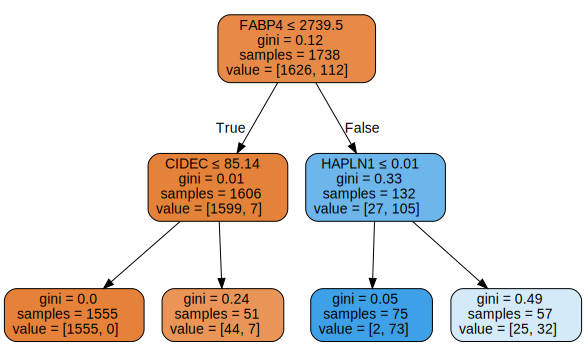

In [20]:
draw_tree(m, train_ob.train.xs, size=10, leaves_parallel=False, precision=2)

## Random Forest Model

In [21]:
def rf(xs, ys, n_estimators=40, max_samples=None,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    """Random Forest Regressor setup helper with some standard parameters"""
    return RandomForestRegressor(n_jobs=-1,  # use all processors
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  max_features=max_features,
                                  min_samples_leaf=min_samples_leaf,
                                  oob_score=True).fit(xs, ys)

def rfc(xs, ys, n_estimators=40, max_samples=None,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    """Random Forest setup helper with some standard parameters"""
    return RandomForestClassifier(n_jobs=-1,  # use all processors
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  max_features=max_features,
                                  min_samples_leaf=min_samples_leaf,
                                  oob_score=True).fit(xs, ys)

In [22]:
# Some convenience variables

valid_xs = train_ob.valid.xs
valid_ys = train_ob.valid.ys
xs = train_ob.train.xs
ys = train_ob.train.ys

In [23]:
# for random forest classifier
# Rather than one-hot encoding the tissues, create a single row of int values
def cat_encode(row):
    for i,tissue in enumerate(train_ob.y_names):
        if row[tissue]:
            return i+1
    return 0
ysc = ys.apply(cat_encode, axis=1)
valid_ysc = valid_ys.apply(cat_encode, axis=1)
        

In [24]:
# We have a over 54 thousand genes
train_ob.x_names

(#54393) ['DDX11L1','WASH7P','MIR6859-1','MIR1302-2HG','FAM138A','OR4G4P','OR4G11P','OR4F5','RP11-34P13.7','CICP27'...]

## Random Forests with Different Hyperparameters

[I 230227 15:37:56 1201816113:13] Starting traing log2 genes with 50 estimators


CPU times: user 6.58 s, sys: 42.5 ms, total: 6.63 s
Wall time: 6.16 s


[I 230227 15:38:03 1201816113:15] 	 'log2' train 0.9822, valid: 0.9494
[I 230227 15:38:06 1201816113:13] Starting traing sqrt genes with 50 estimators


CPU times: user 12.5 s, sys: 453 µs, total: 12.5 s
Wall time: 6.48 s


[I 230227 15:38:13 1201816113:15] 	 'sqrt' train 0.9937, valid: 0.9764
[I 230227 15:38:15 1201816113:13] Starting traing 0.1 genes with 50 estimators


CPU times: user 2min 47s, sys: 30.8 ms, total: 2min 47s
Wall time: 27.5 s


[I 230227 15:38:43 1201816113:15] 	 '0.1' train 0.9954, valid: 0.981
[I 230227 15:38:46 1201816113:13] Starting traing 0.2 genes with 50 estimators


CPU times: user 5min 31s, sys: 73.2 ms, total: 5min 31s
Wall time: 49.5 s


[I 230227 15:39:36 1201816113:15] 	 '0.2' train 0.9965, valid: 0.981


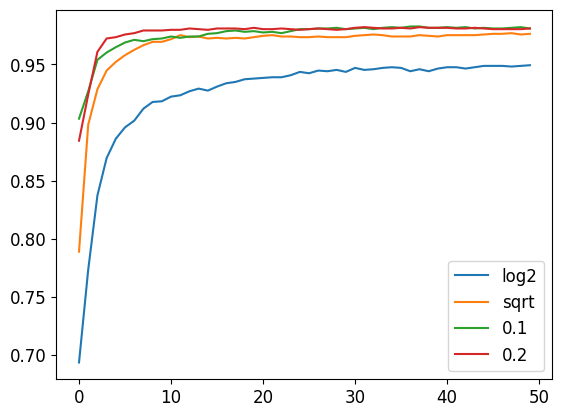

In [25]:
#'features' are genes to use
max_feature_list = [
    'log2',
    'sqrt', # default
    0.1,
    0.2,
    # 0.5,  # fraction of features to use.  Half.
    # None,  # Use all features
]

ESTIMATORS = 50
for mf in max_feature_list:
    logger.info(f"Starting traing {mf} genes with {ESTIMATORS} estimators")
    %time m = rf(xs, ys, n_estimators=ESTIMATORS, max_features=mf)
    logger.info(f"\t '{mf}' train {round(rf_accuracy(m, xs, ys), 4)}, valid: {round(rf_accuracy(m, valid_xs, valid_ys), 4)}")
    preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])
    plt.plot([accuracy(tensor(preds[:i+1].mean(0)), valid_ys) for i in range(ESTIMATORS)])
    
    # Random forest classifier
    """
    %time m = rfc(xs, yso, n_estimators=ESTIMATORS, max_features=mf)
    logger.info(f"\t '{mf}' train {round(rf_accuracy(m, xs, ysc), 4)}, valid: {round(rf_accuracy(m, valid_xs, valid_ysc), 4)}")
    preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
    plt.plot([accuracy(tensor(preds[:i+1].mean(0)), valid_ysc) for i in range(ESTIMATORS)])
    """
plt.legend([str(i) for i in max_feature_list])

In [26]:
xs.values

array([[0.000e+00, 1.565e+00, 0.000e+00, ..., 4.470e+04, 1.799e+00, 1.746e+00],
       [0.000e+00, 6.857e+00, 0.000e+00, ..., 1.587e+04, 8.901e-01, 2.592e+00],
       [0.000e+00, 1.362e+00, 0.000e+00, ..., 5.853e+03, 5.202e+00, 1.683e+00],
       ...,
       [3.214e-02, 8.536e+00, 0.000e+00, ..., 1.216e+04, 0.000e+00, 0.000e+00],
       [0.000e+00, 3.924e+00, 0.000e+00, ..., 2.701e+04, 2.952e+00, 2.865e+00],
       [0.000e+00, 5.042e+00, 0.000e+00, ..., 2.076e+04, 1.260e+00, 6.116e-01]], dtype=float32)

A greater number of features (gene expressions) helps the predictions.
Seem to be diminishing returns after about 10% (~ 5.5k genes)

## Test Running a prediction

### Example - first validation sample

In [27]:
# Just using the first sample of the validation set as an example
valid_xs.iloc[0]

DDX11L1            0.000000
WASH7P             4.459000
MIR6859-1          0.000000
MIR1302-2HG        0.000000
FAM138A            0.041880
                   ...     
MT-ND6         26390.000000
MT-TE            113.900002
MT-CYB         35020.000000
MT-TT              8.509000
MT-TP              4.505000
Name: GTEX-111CU-1126-SM-5EGIM, Length: 54393, dtype: float32

In [28]:
valid_ys.iloc[0]

Adipose Tissue     0.0
Adrenal Gland      0.0
Bladder            0.0
Blood              0.0
Blood Vessel       0.0
Bone Marrow        0.0
Brain              0.0
Breast             0.0
Cervix Uteri       0.0
Colon              0.0
Esophagus          0.0
Fallopian Tube     0.0
Heart              0.0
Kidney             0.0
Liver              0.0
Lung               0.0
Muscle             0.0
Nerve              0.0
Ovary              0.0
Pancreas           0.0
Pituitary          0.0
Prostate           0.0
Salivary Gland     0.0
Skin               1.0
Small Intestine    0.0
Spleen             0.0
Stomach            0.0
Testis             0.0
Thyroid            0.0
Uterus             0.0
Vagina             0.0
Name: GTEX-111CU-1126-SM-5EGIM, dtype: float32

In [29]:
# single prediction of a set
pred = m.predict(valid_xs.iloc[0:1])
pred
# valid_xs.iloc[0:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
# See the tissue predicted
tissue_index = pred.argmax()
dep_var[tissue_index]

'Skin'

### Example of a failed prediction

In [31]:
# Find an example of a failed prediction

rf_preds = m.predict(valid_xs)

for i, pred in enumerate(rf_preds):
    p_call = pred.argmax()
    t_call = valid_ys.iloc[i].argmax()
    if p_call != t_call:
        if p_call:  # most failures are no predictions (all zeros)
            break

print(f"predicted valid_xs[{i}] as: {dep_var[p_call]}")
print(f"\tActually is: {dep_var[t_call]}")
pd.Series(pred, index=dep_var)

predicted valid_xs[155] as: Blood Vessel
	Actually is: Adipose Tissue


Adipose Tissue     0.171905
Adrenal Gland      0.000000
Bladder            0.006190
Blood              0.000000
Blood Vessel       0.482985
Bone Marrow        0.000000
Brain              0.000000
Breast             0.020000
Cervix Uteri       0.008252
Colon              0.060000
Esophagus          0.040000
Fallopian Tube     0.001538
Heart              0.000000
Kidney             0.020000
Liver              0.000000
Lung               0.000000
Muscle             0.000000
Nerve              0.000000
Ovary              0.035758
Pancreas           0.020000
Pituitary          0.000000
Prostate           0.007949
Salivary Gland     0.013187
Skin               0.020000
Small Intestine    0.027500
Spleen             0.000000
Stomach            0.004615
Testis             0.000000
Thyroid            0.000000
Uterus             0.036788
Vagina             0.023333
dtype: float64

## Feature Importance

Random Forests have a property .feature_importances_ showing which genes have a large effect on classification.

In [32]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [33]:
fi = rf_feat_importance(m, xs)
fi[:20]

cols       imp
12606         NKX6-1  0.038993
3089         C1orf61  0.031921
28791         NLRP10  0.023158
41371     AC004158.3  0.022409
27796         OPALIN  0.018196
464           FBLIM1  0.017380
15772           PSD2  0.015799
45396  RP11-824M15.3  0.014455
9938         TMEM45A  0.013861
45458       SERPINB7  0.013383
49127         FAM83D  0.012855
23294          FABP4  0.012473
48147          TNNI3  0.012050
20645           GRM3  0.011922
41816         FAM57A  0.011719
12229         IGFBP7  0.011136
49900      LINC00320  0.009750
29359         MYBPC3  0.009588
3101            BCAN  0.009305
23509    KB-1448A5.1  0.008910

<AxesSubplot: ylabel='cols'>

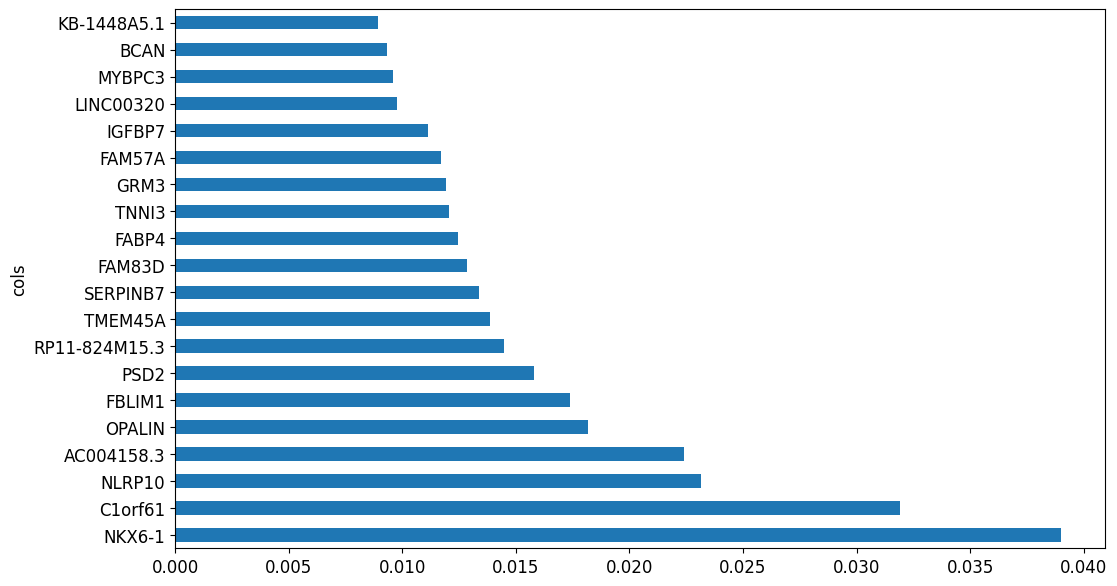

In [34]:
fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

A common action would be to try to drop features of low importance, and see if models build using less genes are still as accurate.

# Neural Network

The fastai TabularPandas training object

In [35]:
learn = tabular_learner(
    train_ob.dataloaders(batch_size=512),  # Use smaller batchsizes to avoid memory errors
    y_range=(0, 1),      # Our 'tissueness' scores should range between 0-1
    layers=[500, 250],   # Default layers are [200, 100]
    n_out=len(dep_var),  # One score per tissue
    metrics=accuracy,
)

In [36]:
learn.summary()

TabularModel (Input shape: 512 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 54393         
BatchNorm1d                               108786     True      
____________________________________________________________________________
                     512 x 500           
Linear                                    27196500   True      
ReLU                                                           
BatchNorm1d                               1000       True      
____________________________________________________________________________
                     512 x 250           
Linear                                    125000     True      
ReLU                                                           
BatchNorm1d                               500        True      
____________________________________________________________________________
                     512 x 31            
Linear                                    7781       

## Find a learning rate parameter

We want a learning rate at the steepest slope - most improvement per step.
Too small and learning takes longer.
Too large and the results will not converge.

SuggestedLRs(valley=0.0012022644514217973)

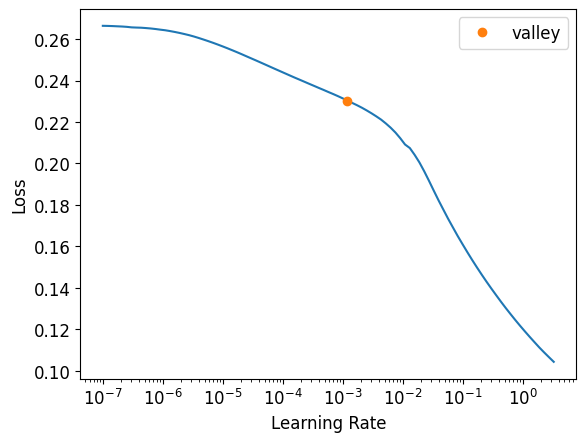

In [37]:
learn.lr_find()

## Train the Neural Network

In [38]:
learn.fit_one_cycle(5, lr_max=1e-3)

### Watch for overfitting
With Neural Nets - watch out for over-fitting.
 - training set loss keeps dropping, but validation gets worse
 - means the neural network has learned idiosyncrasies that do not generalize.

In [39]:
learn.fit_one_cycle(30, 1e-2)

## Example Prediction

Check our call on the first sample of the validation set

In [40]:
full_dec,dec_pred,pred = learn.predict(valid_xs.iloc[0])

<AxesSubplot: >

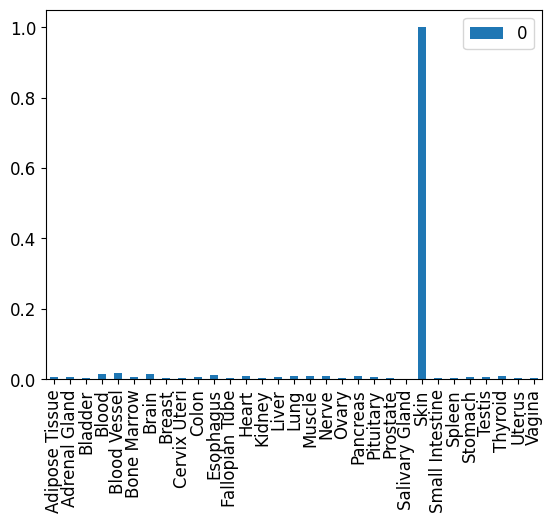

In [41]:
def plot_pred(pred):
    pred_df = pd.DataFrame(pred)
    pred_df.index = dep_var
    return pred_df.plot.bar()

plot_pred(pred)

In [42]:
valid_ys.iloc[0]

Adipose Tissue     0.0
Adrenal Gland      0.0
Bladder            0.0
Blood              0.0
Blood Vessel       0.0
Bone Marrow        0.0
Brain              0.0
Breast             0.0
Cervix Uteri       0.0
Colon              0.0
Esophagus          0.0
Fallopian Tube     0.0
Heart              0.0
Kidney             0.0
Liver              0.0
Lung               0.0
Muscle             0.0
Nerve              0.0
Ovary              0.0
Pancreas           0.0
Pituitary          0.0
Prostate           0.0
Salivary Gland     0.0
Skin               1.0
Small Intestine    0.0
Spleen             0.0
Stomach            0.0
Testis             0.0
Thyroid            0.0
Uterus             0.0
Vagina             0.0
Name: GTEX-111CU-1126-SM-5EGIM, dtype: float32

# Comparing the Neural Network and Random Forest Models

In [43]:
nn_preds, targs = learn.get_preds()
accuracy(nn_preds, targs)

0.9556962251663208

In [44]:
# Find some interesting cases to compare
nn_better = []
rf_better = []
both_fail = []
for i, (pred_rf, pred_nn) in enumerate(zip(rf_preds, nn_preds)):
    tissue_idx = valid_ys.iloc[i].argmax()
    pred_rf_idx = pred_rf.argmax()
    pred_nn_idx = pred_nn.argmax()
    if pred_rf_idx != tissue_idx and pred_nn_idx != tissue_idx:
        # print(f'both failed {i}')
        both_fail.append(i)
    elif pred_rf_idx != tissue_idx and pred_nn_idx == tissue_idx:
        nn_better.append(i)
        # print(f'nn only {i}')
        if pred_rf.max():
            break
    elif pred_rf_idx == tissue_idx and pred_nn_idx != tissue_idx:
        rf_better.append(i)
        # print(f'rf only {i}')

In [45]:
# test on an example where the random forest failed.
idx = nn_better[-1]
_,_,prednn = learn.predict(valid_xs.iloc[idx])

Breast
tensor([0.3321, 0.0040, 0.0058, 0.0064, 0.0028, 0.0056, 0.0049, 0.5176, 0.0021, 0.0044, 0.0120, 0.0021, 0.0091, 0.0068, 0.0045, 0.0075, 0.0066, 0.0074, 0.0053, 0.0057, 0.0052, 0.0070, 0.0049, 0.0048,
        0.0050, 0.0040, 0.0100, 0.0030, 0.0076, 0.0021, 0.0125])


<AxesSubplot: >

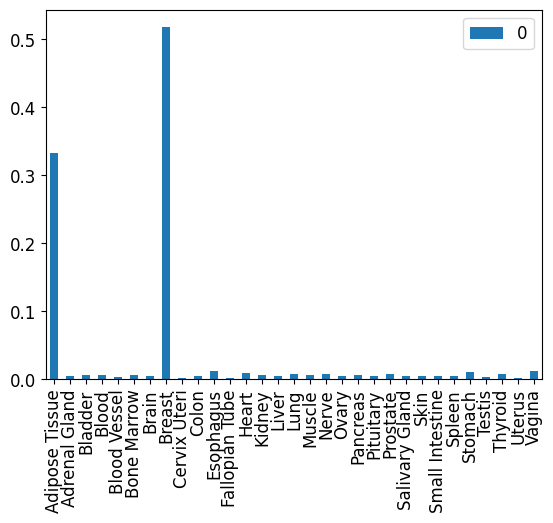

In [46]:
print(dep_var[valid_ys.iloc[idx].argmax()])
print(prednn)
plot_pred(prednn)

<AxesSubplot: >

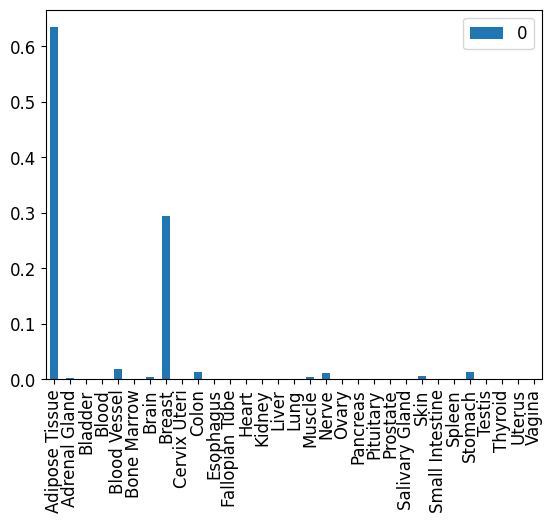

In [47]:
predrf = tensor(m.predict(valid_xs.iloc[idx:idx+1]))[0]
plot_pred(predrf)

<AxesSubplot: >

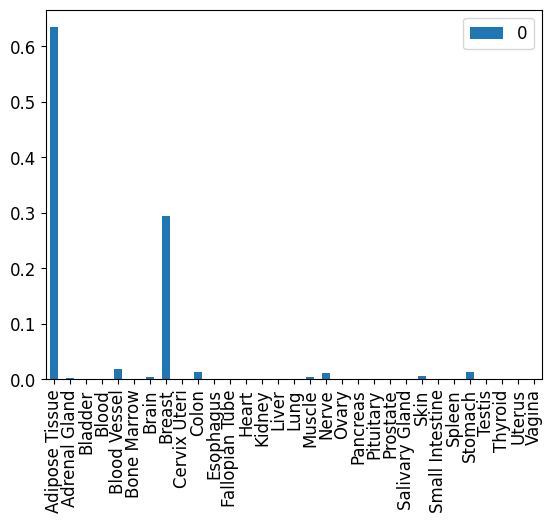

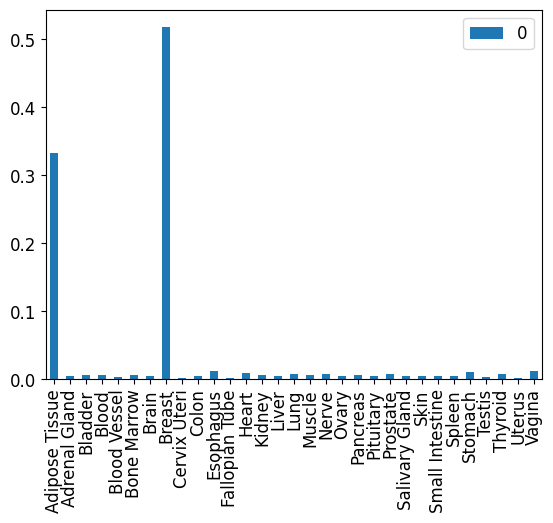

In [48]:
# Most cases of the Randomw forest failure have no prediction from the random forest
plot_pred(rf_preds[nn_better[0]])
plot_pred(nn_preds[nn_better[0]])

## Combine the Calls

By just adding up the scores, the neural net fills in blanks of the Random Forest.

In [49]:
print(accuracy(rf_preds, valid_ys))
print(accuracy(nn_preds, valid_ys))

0.9810126423835754
0.9556962251663208


In [50]:
comb_preds = tensor(rf_preds) + tensor(nn_preds)
accuracy(comb_preds, valid_ys)

0.9787111878395081

# Discussion
